In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *

np.set_printoptions(threshold=50, edgeitems=20)

from itertools import product

from utils import *

# from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
# import lightgbm as lgb
data_path = 'data/'
seed=1204
submission_path=data_path+'submission/'


    

In [3]:
def score(X,emb_szs,emb_dr,nn_list,nn_dr,cv,loss_metric,get_oof=False,cycle_len=1):
    print("Training: ")
    oof_train = np.zeros([0,])
    cv_losses=[]
    for i,(train_idx,val_idx) in enumerate(cv):
        print('CV %d' % i)
        df_train, y_train, nas, mapper = proc_df(X.loc[train_idx], 'Target', do_scale=True)
        df_val, y_val, nas, mapper = proc_df(X.loc[val_idx], 'Target', do_scale=True, mapper=mapper, na_dict=nas)

        md = ColumnarModelData.from_data_frames(data_path, df_train,df_val, y_train.astype(np.float32), y_val.astype(np.float32),
                                        cat_flds=cat_vars, bs=128)
        m = md.get_learner(emb_szs, len(df_train.columns)-len(cat_vars),
                   emb_dr, 1, nn_list, nn_dr, y_range=(1,22),use_bn=True)
        
        lr=1e-3
        temp=m.fit(lr,1, metrics=[loss_metric],cycle_len=cycle_len)
        
        val_pred,val_targ=m.predict_with_targs()
        if get_oof:
            oof_train = np.append(oof_train,val_pred)
        
        val_loss=loss_metric(val_targ,val_pred)
        
        print('Val RMSE: {}'.format(val_loss))
        cv_losses.append(val_loss)
    print('6 fold results: {}'.format(cv_losses))
    
    mean_cv_loss = np.mean(cv_losses)
    print("Mean Cross Validation RMSE: {}\n".format(mean_cv_loss))
    return (oof_train,cv_losses) if get_oof else cv_losses

def get_NN_prediction(X,test_lag,emb_dr,nn_list,nn_dr,prediction_name):
    # preparing test set from whole training set
    


    md = ColumnarModelData.from_data_frame(data_path, [0],df, y.astype(np.float32),
                                            cat_flds=cat_vars, bs=128,test_df = df_test)

    m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
               emb_dr, 1, nn_list, nn_dr, y_range=(1,22),use_bn=True)
    lr=1e-3
    m.fit(lr,1, metrics=[root_mean_squared_error],cycle_len=1)
    
    pred_test = m.predict(True)
    pred_test = np.squeeze(pred_test)
    
    get_submission(pred_test,prediction_name); 

In [4]:
# # #get sample for tuning
# all_data= get_all_data_sample(data_path,'new_sales_lag_after12_month.pickle')

# cv = get_cv_idxs(all_data,31,33)
# X,y = get_X_y(all_data,33)
# val_idxs = X[X.date_block_num == 33].index.values
# X['Target'] = y
# X.drop('date_block_num',axis=1,inplace=True)

# test_lag = pd.read_csv(data_path+'test_lag_both_month.csv')
# test_lag.drop(['ID','item_name'],axis=1,inplace=True)
# test_lag.drop('date_block_num',axis=1,inplace=True)
# test_lag['Target'] = 0


# for i in ['December','Newyear_Xmas','Valentine_MenDay','WomenDay','Easter_Labor']:
#     X[i] = X[i] ==1
#     test_lag[i] = test_lag[i]==1

# lag_features=['_'.join(i) for i in list(product(*[['item_block_target','shop_block_target','item_cat_block_target'],['mean','sum'],['lag'], map(str,[1,2,3,5,12])]))]
# lag_features+=['target_lag_%d'% i for i in [1,2,3,5,12]]

# cat_vars = ['shop_id','item_id','item_category_id','month','December','Newyear_Xmas','Valentine_MenDay','WomenDay','Easter_Labor']
# contin_vars = lag_features

# n = len(X); 

# # categories fastai preprocess
# for v in cat_vars: X[v] = X[v].astype('category').cat.as_ordered()
# apply_cats(test_lag, X)


# #numerical fastai preprocess
# for v in contin_vars:
#     X[v]= X[v].astype('float32')
#     test_lag[v] = test_lag[v].astype('float32')

# cat_sz = [(c, len(X[c].cat.categories)+1) for c in cat_vars]

# emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

# emb_szs

In [25]:
# %%time
# score(X,emb_szs,0,[400,200],[0,0],use_bn=True)

Training: 
CV 0


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error       
    0      1.671485   1.355453   1.150732  
    1      1.360393   1.342583   1.147006                      

Val RMSE: 1.1587056554150446
CV 1


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error       
    0      1.516818   1.52548    1.209676  
    1      1.437991   1.492941   1.200262                      

Val RMSE: 1.2218150697337962
CV 2


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error       
    0      1.441671   1.53478    1.219048  
    1      1.39009    1.584659   1.239767                      

Val RMSE: 1.2590732298105272
6 fold results: [1.1587056554150446, 1.2218150697337962, 1.2590732298105272]
Mean Cross Validation RMSE: 1.213197984986456

CPU times: user 5min 27s, sys: 36.5 s, total: 6min 4s
Wall time: 5min 24s


In [36]:
# %%time
# score(X,emb_szs,0.01,[400,100],[0,0],use_bn=True)

Training: 
CV 0


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error       
    0      1.583864   1.356976   1.152622  
    1      1.32899    1.324298   1.140432                      

Val RMSE: 1.1507518570325785
CV 1


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error       
    0      1.354508   1.522382   1.208437  
    1      1.325968   1.481782   1.201085                      

Val RMSE: 1.217223507467319
CV 2


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error       
    0      1.50295    1.555701   1.22749   
    1      1.610169   1.587347   1.242403                      

Val RMSE: 1.260167588563106
6 fold results: [1.1507518570325785, 1.217223507467319, 1.260167588563106]
Mean Cross Validation RMSE: 1.2093809843543344

CPU times: user 5min 29s, sys: 38.1 s, total: 6min 7s
Wall time: 5min 15s


In [21]:
# %%time
# score(X,emb_szs,0,[200,100],[0,0],use_bn=True)

Training: 
CV 0


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error       
    0      1.780093   1.32765    1.139885  
    1      1.302263   1.340018   1.145224                      

Val RMSE: 1.1575860217697131
CV 1


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error       
    0      1.366145   1.533122   1.213496  
    1      1.366302   1.514345   1.210965                      

Val RMSE: 1.2305503212669386
CV 2


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error       
    0      1.420116   1.531681   1.217755  
    1      1.560694   1.553411   1.227447                      

Val RMSE: 1.2465898249823688
6 fold results: [1.1575860217697131, 1.2305503212669386, 1.2465898249823688]
Mean Cross Validation RMSE: 1.2115753893396735

CPU times: user 5min 27s, sys: 36.2 s, total: 6min 3s
Wall time: 5min 25s


# ---------------------------------------------------

# Full dataset

In [4]:
# #get sample for tuning
all_data= get_all_data(data_path,'new_sales_lag_after12_month.pickle')

cv = get_cv_idxs(all_data,28,33)
X,y = get_X_y(all_data,33)
val_idxs = X[X.date_block_num == 33].index.values
X['Target'] = y
X.drop('date_block_num',axis=1,inplace=True)

test_lag = pd.read_csv(data_path+'test_lag_month.csv')
test_lag.drop(['ID','item_name'],axis=1,inplace=True)
test_lag.drop('date_block_num',axis=1,inplace=True)
test_lag['Target'] = 0


for i in ['December','Newyear_Xmas','Valentine_MenDay','WomenDay','Easter_Labor']:
    X[i] = X[i] ==1
    test_lag[i] = test_lag[i]==1

lag_features=['_'.join(i) for i in list(product(*[['item_block_target','shop_block_target','item_cat_block_target'],['mean','sum'],['lag'], map(str,[1,2,3,5,12])]))]
lag_features+=['target_lag_%d'% i for i in [1,2,3,5,12]]

cat_vars = ['shop_id','item_id','item_category_id','month','December','Newyear_Xmas','Valentine_MenDay','WomenDay','Easter_Labor']
contin_vars = lag_features

n = len(X); 

# categories fastai preprocess
for v in cat_vars: X[v] = X[v].astype('category').cat.as_ordered()
apply_cats(test_lag, X)


#numerical fastai preprocess
for v in contin_vars:
    X[v]= X[v].astype('float32')
    test_lag[v] = test_lag[v].astype('float32')

In [5]:
cat_sz = [(c, len(X[c].cat.categories)+1) for c in cat_vars]

emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

emb_szs

[(56, 28),
 (17055, 50),
 (80, 40),
 (13, 7),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2)]

In [6]:
len(cat_vars)+len(contin_vars)
X.shape
test_lag.shape

44

(6425094, 45)

(214200, 45)

# ------------------- New CV on dataset with month 

In [7]:
df, y, nas, mapper = proc_df(X, 'Target', do_scale=True)
df_test, temp, nas, mapper = proc_df(test_lag, 'Target', do_scale=True, mapper=mapper, na_dict=nas)

In [8]:
oof_train2,_ = score(X,emb_szs,0.01,[600,200],[0.001,0.01],cv,root_mean_squared_error,get_oof=True)
oof_df = pd.Series(oof_train2)
oof_df.to_pickle(data_path+'oof/fastai600200.pickle')

Training: 
CV 0


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error         
    0      1.306255   1.524316   1.178312  

Val RMSE: 1.2348621710805854
CV 1


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error         
    0      1.232704   1.513714   1.174999  

Val RMSE: 1.2307802805037757
CV 2


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error         
    0      1.160553   1.330471   1.115696  

Val RMSE: 1.1537706237305285
CV 3


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error         
    0      1.197653   1.354066   1.123157  

Val RMSE: 1.1638183849823656
CV 4


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error         
    0      1.309049   1.572057   1.188231  

Val RMSE: 1.2540228008162535
CV 5


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error         
    0      1.296942   1.659282   1.207861  

Val RMSE: 1.2882883232482352
6 fold results: [1.2348621710805854, 1.2307802805037757, 1.1537706237305285, 1.1638183849823656, 1.2540228008162535, 1.2882883232482352]
Mean Cross Validation RMSE: 1.2209237640602906



In [8]:
#get_prediction for this
get_NN_prediction(X,test_lag,0.01,[600,200],[0.001,0.01],'fastai_600200')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error         
    0      1.245784   6.134883   2.47687   



# --------------------

In [10]:
oof_train4,_ = score(X,emb_szs,0.01,[1000,500],[0.01,0.01],cv,root_mean_squared_error,get_oof=True)
oof_df = pd.Series(oof_train4)
oof_df.to_pickle(data_path+'oof/fastai1000500.pickle')

Training: 
CV 0


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error         
    0      1.202618   1.620508   1.214209  

Val RMSE: 1.273256019813243
CV 1


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error         
    0      1.30266    1.454026   1.154273  

Val RMSE: 1.2062637703855703
CV 2


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error         
    0      1.299608   1.392194   1.1373    

Val RMSE: 1.1798428565794763
CV 3


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error         
    0      1.407389   1.370113   1.118261  

Val RMSE: 1.1707010619813893
CV 4


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error         
    0      1.450156   1.590725   1.171063  

Val RMSE: 1.2614803502339975
CV 5


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error         
    0      1.236541   1.615571   1.194604  

Val RMSE: 1.2712071551639517
6 fold results: [1.273256019813243, 1.2062637703855703, 1.1798428565794763, 1.1707010619813893, 1.2614803502339975, 1.2712071551639517]
Mean Cross Validation RMSE: 1.2271252023596046



In [ ]:
#get_prediction
get_NN_prediction(X,test_lag,0.01,[1000,500],[0.01,0.01],'fastai_1000500')

# --------------------------------

In [11]:
oof_train5,_ = score(X,emb_szs,0.01,[500,500],[0.01,0.01],cv,root_mean_squared_error,get_oof=True)
oof_df = pd.Series(oof_train5)
oof_df.to_pickle(data_path+'oof/fastai500500.pickle')

Training: 
CV 0


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error         
    0      1.234263   1.564236   1.195142  

Val RMSE: 1.2509385400215531
CV 1


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error         
    0      1.20241    1.472716   1.161214  

Val RMSE: 1.2139938668939811
CV 2


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error         
    0      1.233672   1.363449   1.128078  

Val RMSE: 1.168029630471332
CV 3


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error         
    0      1.24778    1.354629   1.124367  

Val RMSE: 1.1640613735116718
CV 4


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error         
    0      1.230591   1.594333   1.197204  

Val RMSE: 1.2629112064986507
CV 5


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error         
    0      1.266771   1.635074   1.203331  

Val RMSE: 1.278857532801399
6 fold results: [1.2509385400215531, 1.2139938668939811, 1.168029630471332, 1.1640613735116718, 1.2629112064986507, 1.278857532801399]
Mean Cross Validation RMSE: 1.223132025033098



In [ ]:
#get_prediction
get_NN_prediction(X,test_lag,0.01,[500,500],[0.01,0.01],'fastai_500500')

# --------------------------

In [14]:
oof_train,_ = score(X,emb_szs,0.01,[300,300],[0.01,0.01],cv,root_mean_squared_error,get_oof=True)
oof_df = pd.Series(oof_train)
oof_df.to_pickle(data_path+'oof/fastai300300.pickle')

Training: 
CV 0


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error         
    0      1.224658   1.590672   1.20438   

Val RMSE: 1.26147203424869
CV 1


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error         
    0      1.282334   1.459101   1.153554  

Val RMSE: 1.208367752812693
CV 2


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error         
    0      1.132771   1.349296   1.121769  

Val RMSE: 1.1619515961038276
CV 3


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error         
    0      1.264665   1.355599   1.125115  

Val RMSE: 1.1644785604734975
CV 4


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error         
    0      1.217587   1.571049   1.18806   

Val RMSE: 1.2536485829129698
CV 5


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error         
    0      1.241406   1.674351   1.217177  

Val RMSE: 1.2941355439468338
6 fold results: [1.26147203424869, 1.208367752812693, 1.1619515961038276, 1.1644785604734975, 1.2536485829129698, 1.2941355439468338]
Mean Cross Validation RMSE: 1.224009011749752



In [ ]:
#get_prediction
get_NN_prediction(X,test_lag,0.01,[300,300],[0.01,0.01],'fastai_300300')

# Get prediction

In [17]:
emb_dr=0.01
nn_list=[1000,500]
nn_dr=[0.1,0.01]

%%time
# preparing test set from whole training set
df, y, nas, mapper = proc_df(X, 'Target', do_scale=True)

df_test, temp, nas, mapper = proc_df(test_lag, 'Target', do_scale=True, mapper=mapper, na_dict=nas)


md = ColumnarModelData.from_data_frame(data_path, val_idxs,df, y.astype(np.float32),
                                        cat_flds=cat_vars, bs=128,test_df = df_test)

m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
           emb_dr, 1, nn_list, nn_dr, y_range=(1,22),use_bn=True)
lr=1e-3
m.fit(lr,1, metrics=[root_mean_squared_error],cycle_len=2)

val_pred,val_targ=m.predict_with_targs()
root_mean_squared_error(val_targ,val_pred)

pd.Series(np.squeeze(val_pred)).describe()

In [9]:
# md = ColumnarModelData.from_data_frames(data_path, df,df_test, y.astype(np.float32), temp.astype(np.float32),
#                                         cat_flds=cat_vars, bs=128,test_df = df_test)

In [ ]:
# m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
#            emb_dr, 1, nn_list, nn_dr, y_range=(1,22),use_bn=True)
# m.lr_find()

In [10]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
           emb_dr, 1, nn_list, nn_dr, y_range=(1,22),use_bn=True)
lr=1e-3
m.fit(lr,1, metrics=[root_mean_squared_error],cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error         
    0      1.277388   1.993644   1.287577  
    1      1.219992   2.27311    1.364067                        



[2.2731102, 1.3640668911762088]

In [72]:
# lr=1e-3
# m.fit(lr, 1, metrics=[root_mean_squared_error], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error          
    0      0.416414   1.012485   0.746727  



[1.012485, 0.7467272461301608]

In [68]:
# lr=1e-3
# m.fit(lr, 1, metrics=[root_mean_squared_error], cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   root_mean_squared_error          
    0      0.381608   1.16338    0.820828  
    1      0.323023   1.400359   0.874565                         



[1.4003593, 0.8745647269191331]

In [74]:
val_pred,val_targ=m.predict_with_targs()
root_mean_squared_error(val_targ,val_pred)

1.00652899813392

In [75]:
pred_test = m.predict(True)
pred_test = np.squeeze(pred_test)

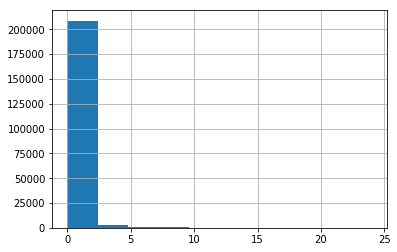

In [76]:
pd.Series(pred_test).hist()

In [77]:
get_submission(pred_test,'default_fastai_all_features_1epoch');